In [44]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
voila 0.3.1 requires nbconvert<7,>=6.0.0, but you have nbconvert 5.6.1 which is incompatible.


In [45]:
from fastbook import *
from fastai.vision.widgets import *

In [46]:
key = os.environ.get('AZURE_SEARCH_KEY', 'f431984882dc41adbcefdceed3392ffa')

In [47]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [48]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [49]:
#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [50]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

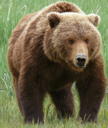

In [51]:
im = Image.open(dest)
im.to_thumb(128,128)

In [52]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [53]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [54]:
fns = get_image_files(path)
fns

(#440) [Path('bears/grizzly/00000047.jpg'),Path('bears/grizzly/00000055.jpg'),Path('bears/grizzly/00000107.jpg'),Path('bears/grizzly/00000036.jpg'),Path('bears/grizzly/00000030.jpg'),Path('bears/grizzly/00000091.jpeg'),Path('bears/grizzly/00000097.jpg'),Path('bears/grizzly/00000148.jpg'),Path('bears/grizzly/00000110.jpg'),Path('bears/grizzly/00000029.jpg')...]

In [55]:
failed = verify_images(fns)
failed

(#0) []

In [56]:
failed.map(Path.unlink);

In [57]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [58]:
dls = bears.dataloaders(path)

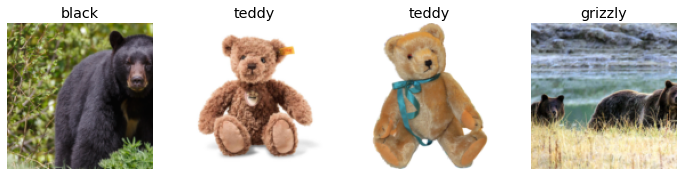

In [59]:
dls.valid.show_batch(max_n=4, nrows=1)

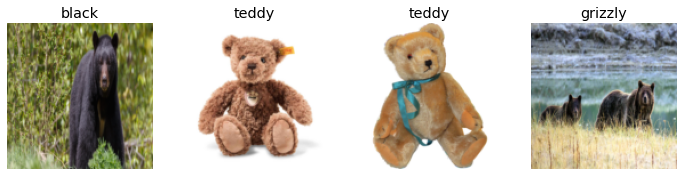

In [60]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

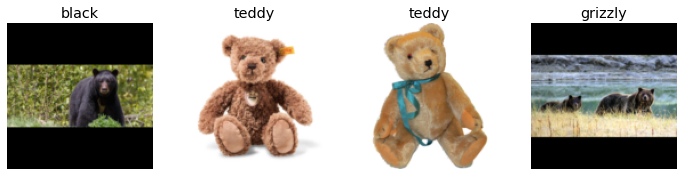

In [61]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

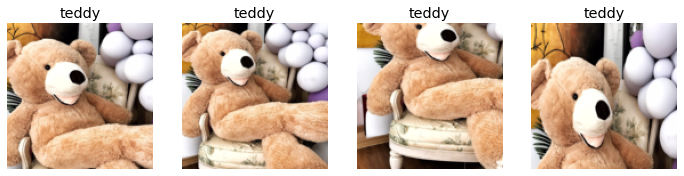

In [62]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

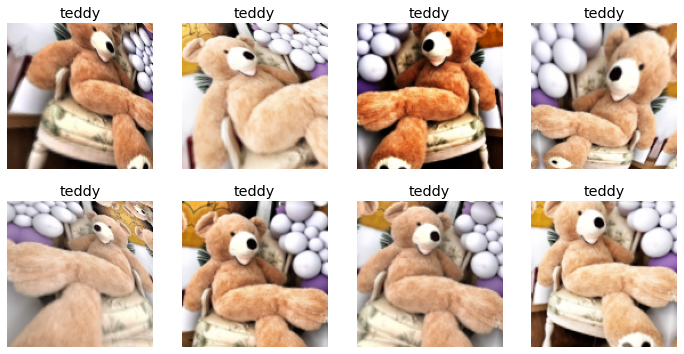

In [63]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [64]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [65]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.006290,0.130670,0.056818,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.148198,0.041929,0.022727,00:16
1,0.125677,0.037466,0.022727,00:16
2,0.091204,0.049709,0.034091,00:16
3,0.070755,0.049869,0.022727,00:15


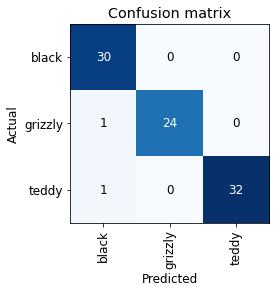

In [66]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

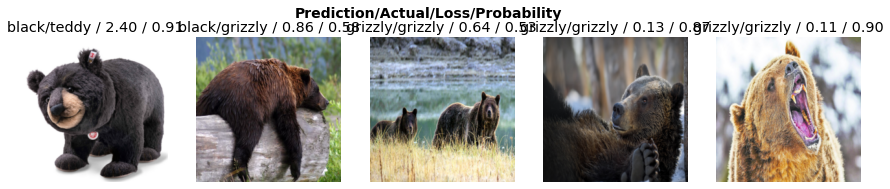

In [67]:
interp.plot_top_losses(5, nrows=1)

In [68]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [69]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [70]:
learn.export()

In [71]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [72]:
learn_inf = load_learner(path/'export.pkl')

In [73]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.4455e-05, 9.9998e-01, 3.2831e-06]))

In [74]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [75]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [76]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [77]:
img = PILImage.create(btn_upload.data[-1])

In [78]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [79]:
pred,pred_idx,probs = learn_inf.predict(img)

In [80]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [81]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [82]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [83]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [84]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [85]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

  Using cached nbconvert-6.4.2-py3-none-any.whl (558 kB)
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.23 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.3.1 OK


<img alt="Deploying to Binder" width="800" caption="Deploying to Binder" id="deploy-binder" src="images/att_00001.png">